<a href="https://colab.research.google.com/github/HimaVarshini-Pasupuleti/MLproject/blob/main/Himavarshini_ml_internship_task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import time

# Load IMDb dataset
NUM_WORDS = 10000
MAXLEN = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
# Decode to text for traditional model
word_index = imdb.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

def decode_review(text_ids):
    return ' '.join([index_word.get(i, '?') for i in text_ids])

X_train_text = [decode_review(x) for x in X_train]
X_test_text = [decode_review(x) for x in X_test]

# TF-IDF for traditional model
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Logistic Regression Model
start_lr = time.time()
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
end_lr = time.time()
# Evaluation for Logistic Regression
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

# Deep Learning (BiLSTM)
X_train_dl = pad_sequences(X_train, maxlen=MAXLEN)
X_test_dl = pad_sequences(X_test, maxlen=MAXLEN)

model = Sequential()
model.add(Embedding(input_dim=NUM_WORDS, output_dim=128, input_length=MAXLEN))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_dl_train = time.time()
model.fit(X_train_dl, y_train, epochs=2, batch_size=128, validation_split=0.2)
end_dl_train = time.time()

# Inference timing
start_dl = time.time()
dl_pred_prob = model.predict(X_test_dl, batch_size=128)
dl_pred = (dl_pred_prob > 0.5).astype("int32")
end_dl = time.time()

# Evaluation for BiLSTM
dl_accuracy = accuracy_score(y_test, dl_pred)
dl_f1 = f1_score(y_test, dl_pred)

# Summary
print("\n📊 Model Comparison Results:")
print(f"Logistic Regression - Accuracy: {lr_accuracy:.4f}, F1-Score: {lr_f1:.4f}, Inference Time: {end_lr - start_lr:.2f}s")
print(f"BiLSTM - Accuracy: {dl_accuracy:.4f}, F1-Score: {dl_f1:.4f}, Inference Time: {end_dl - start_dl:.2f}s")


Epoch 1/2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.6860 - loss: 0.5672 - val_accuracy: 0.8532 - val_loss: 0.3533
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8919 - loss: 0.2777 - val_accuracy: 0.8460 - val_loss: 0.3501
196/196 ━━━━━━━━━━━━━━━━━━━━ 113s 573ms/step

📊 Model Comparison Results:
Logistic Regression - Accuracy: 0.8839, F1-Score: 0.8845, Inference Time: 1.11s
BiLSTM             - Accuracy: 0.8461, F1-Score: 0.8323, Inference Time: 142.05s


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import time

# Load
df = pd.read_csv('heart.csv')
X = df.drop('target', axis=1)
y = df['target']

# Preprocess
# (handle missing, encode, scale — pseudocode)
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Manual model: Logistic Regression
lr = LogisticRegression(max_iter=1000)
t0 = time.time()
lr.fit(X_train, y_train)
t1 = time.time()
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
print(f"LR — Acc: {acc:.4f}, AUC: {roc:.4f}, Time: {t1-t0:.2f}s")

LR — Acc: 0.7951, AUC: 0.8790, Time: 0.01s


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import tensorflow_datasets as tfds

# Load the dataset (automatically splits into train/test)
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

# Preprocessing function
IMG_SIZE = 160  # MobileNetV2 default

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Apply preprocessing
ds_train = ds_train.map(format_example).batch(32).prefetch(1)
ds_val = ds_val.map(format_example).batch(32).prefetch(1)

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=3)  # You can increase for better results

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 555s 942ms/step - accuracy: 0.9658 - loss: 0.0890 - val_accuracy: 0.9845 - val_loss: 0.0445
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 560s 939ms/step - accuracy: 0.9849 - loss: 0.0405 - val_accuracy: 0.9845 - val_loss: 0.0414
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 500s 859ms/step - accuracy: 0.9897 - loss: 0.0294 - val_accuracy: 0.9850 - val_loss: 0.0442


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━

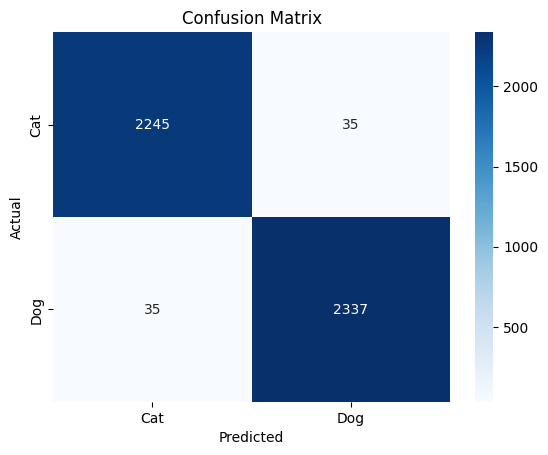

In [ ]:
# Get predictions
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.round(preds).astype(int).flatten())

# Classification Report
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# TASK 5
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import gradio as gr

df = pd.read_csv("heart.csv")
X = df.drop("target", axis=1)
y = df["target"]

X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

def predict_heart_disease(
    age, sex, cp, trestbps, chol, fbs, restecg,
    thalach, exang, oldpeak, slope, ca, thal):
  input_dict = {
      "age": [age],
      "sex": [sex],
      "cp": [cp],
      "trestbps": [trestbps],
      "chol": [chol],
      "fbs": [fbs],
      "restecg": [restecg],
      "thalach": [thalach],
      "exang": [exang],
      "oldpeak": [oldpeak],
      "slope": [slope],
      "ca": [ca],
      "thal": [thal],
      }
  df_input = pd.DataFrame(input_dict)
  df_input_encoded = pd.get_dummies(df_input, drop_first=True)
  df_input_encoded = df_input_encoded.reindex(columns=X_encoded.columns, fill_value=0)
  scaled_input = scaler.transform(df_input_encoded)
  pred = model.predict(scaled_input)[0]
  prob = model.predict_proba(scaled_input)[0][1]
  return f"Prediction: {'Heart Disease' if pred==1 else 'No Heart Disease'} (Prob: {prob:.2f})"

inputs = [
    gr.Number(label="Age"),
    gr.Number(label="Sex (1=Male, 0=Female)"),
    gr.Number(label="Chest Pain Type (0-3)"),
    gr.Number(label="Resting BP"),
    gr.Number(label="Cholesterol"),
    gr.Number(label="Fasting Blood Sugar (>120mg/dl, 1=True, 0=False)"),
    gr.Number(label="Rest ECG (0-2)"),
    gr.Number(label="Max Heart Rate Achieved"),
    gr.Number(label="Exercise Induced Angina (1=Yes, 0=No)"),
    gr.Number(label="ST Depression (oldpeak)"),
    gr.Number(label="Slope (0-2)"),
    gr.Number(label="CA (0-3)"),
    gr.Number(label="Thal (1=Normal, 2=Fixed Defect, 3=Reversable Defect)"),
    ]
output = gr.Textbox(label="Result")
app = gr.Interface(fn=predict_heart_disease, inputs=inputs, outputs=output,
                   title="Heart Disease Prediction App",
                   description="Enter patient details and get a prediction.")
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd945092866ee672d9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
